In [2]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import sys
sys.path.append('../')
import utils.vmf as vmf_utils
import utils.plot as plot_utils
from methods import s3wd, sswd, wd

import time
from itertools import cycle
from scipy.stats import gaussian_kde

from tqdm.auto import trange
from tqdm import tqdm

import matplotlib.pyplot as plt

device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [35]:
phi = (1 + np.sqrt(5)) / 2

vs = np.array([
    [-1,  phi,  0],
    [ 1,  phi,  0],
    [-1, -phi,  0],
    [ 1, -phi,  0],
    [ 0, -1,  phi],
    [ 0,  1,  phi],
    [ 0, -1, -phi],
    [ 0,  1, -phi],
    [ phi,  0, -1],
    [ phi,  0,  1],
    [-phi,  0, -1],
    [-phi,  0,  1]
])

mus = F.normalize(torch.tensor(vs, dtype=torch.float), p=2, dim=-1)

X = []
kappa = 50 
N = 200   
for mu in mus:
    vmf = vmf_utils.rand_vmf(mu, kappa=kappa, N=N)
    X += list(vmf)

X = torch.tensor(X, dtype=torch.float)
Xt = X.clone().detach()

trainloader = DataLoader(Xt, batch_size=2400, shuffle=True)
dataiter = iter(cycle(trainloader))

In [36]:
def KL(X, Y, n_samples=10000):
    samples = utils.vmf.rand_u_hypersphere(n_samples, X.shape[1])
    kde_x = gaussian_kde(X.T, bw_method='silverman')
    kde_y = gaussian_kde(Y.T, bw_method='silverman')
    density_x = np.maximum(kde_x(samples.T), np.finfo(float).eps)
    density_y = np.maximum(kde_y(samples.T), np.finfo(float).eps)
    kl = np.mean(np.log(density_x / density_y))
    return kl
def target_density(x):
    m = torch.matmul(x, mus.T)
    return torch.sum(torch.exp(10*m),dim=-1)

def vmf_pdf(x, mu, kappa):
    kappa = torch.tensor(kappa, dtype=torch.float32, device=x.device)
    mu=mu.to(device)
    C_d = kappa / (2 * np.pi * (torch.exp(kappa) - torch.exp(-kappa)))
    return C_d * torch.exp(kappa * torch.matmul(x, mu.T))

V=lambda x: -torch.log(target_density(x))
target=lambda x: np.exp(-V(torch.tensor(x,dtype=torch.float)).cpu().numpy())

In [37]:
def plot_sphere(ax, X, ps=5):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x_ = np.outer(np.cos(u), np.sin(v))
    y_ = np.outer(np.sin(u), np.sin(v))
    z_ = np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(x_, y_, z_, color='w', alpha=0.2)
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    ax.scatter(x, y, z, s=ps, color='b')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    ax.set_box_aspect([1, 1, 1])

In [69]:
#gradient flows
def run_exp(dataiter, d_func, d_args, device='cpu', n_steps=500, lr=1e-2):
    # scheduler = LinearRS(1, 100, n_steps)
    X0 = torch.randn((2400, 3), device=device)
    X0 = F.normalize(X0, p=2, dim=-1)
    X0.requires_grad_(True)

    optimizer = torch.optim.Adam([X0], lr=lr)

    tic = time.time()
    pbar = trange(n_steps)

    for k in pbar:
        optimizer.zero_grad()
        Xt = next(dataiter).to(device)
        sw = d_func(Xt, X0, **d_args)
        sw.backward()
        optimizer.step()
        X0.data /= torch.norm(X0.data, dim=1, keepdim=True)
        pbar.set_description(f"Loss: {sw.item():.4f}")
    
    pbar.close()
    t = time.time() - tic
    X0_np = X0.detach().cpu().numpy()
    Xt_np = Xt.detach().cpu().numpy()

    w = wd.g_wasserstein(torch.tensor(X0_np, device=device), torch.tensor(Xt_np, device=device), p=2, device=device)    
    log_probs = torch.stack([vmf_pdf(X0, mu, kappa) for mu in mus])
    log_sum_probs = torch.logsumexp(log_probs, dim=0) - torch.log(torch.tensor(len(mus), device=device))
    nll = -torch.sum(log_sum_probs).item()

    return X0_np, t, nll, w.item()

In [102]:
N = 10
d_func = s3wd.ari_s3wd
d_args = {'p': 2, 'n_projs': 1000, 'device': device, 'h': None, 'n_rotations': 30, 'pool_size': 1000}
results = [run_exp(dataiter, d_func, d_args, lr=0.01,device= device) for _ in range(N)]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [103]:
runtimes = [r[1] for r in results]
nll=[r[2] for r in results]
w = [r[3] for r in results] 

print("Runtime: Mean =", np.mean(runtimes), "Std =", np.std(runtimes), "Min =", np.min(runtimes), "Max =", np.max(runtimes))
print("NLL: Mean =", np.mean(nll), "Std =", np.std(nll), "Min =", np.min(nll), "Max =", np.max(nll))
log_wd = np.log(w)  
print("Log Wasserstein: Mean =", np.mean(log_wd), 
      "Std =", np.std(log_wd), 
      "Min =", np.min(log_wd), 
      "Max =", np.max(log_wd))

Runtime: Mean = 51.491778922081 Std = 0.11039525899763425 Min = 51.372536420822144 Max = 51.75388169288635
NLL: Mean = -4971.2244140625 Std = 1.4447646831842933 Min = -4972.93359375 Max = -4968.7939453125
Log Wasserstein: Mean = -9.042839520984014 Std = 0.3912403211121852 Min = -9.79709841442537 Max = -8.73159464794839


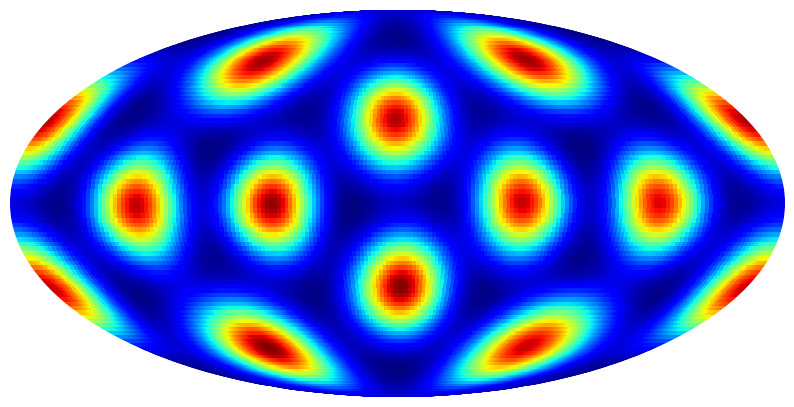

In [53]:
best = np.argmin(w)
X0_best = results[best][0]
k = gaussian_kde(X0_best.T)
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
plot_utils.projection_mollweide(lambda x: k.pdf(x.T), ax)
plt.show()

In [95]:
N = 10
d_func = s3wd.s3wd
d_args = {'p': 2, 'n_projs': 1000, 'device': device, 'h': None}
results1 = [run_exp(dataiter, d_func, d_args, lr=0.01,device= device) for _ in range(N)]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [96]:
runtimes = [r[1] for r in results1]
nll=[r[2] for r in results1]
w = [r[3] for r in results1] 

print("Runtime: Mean =", np.mean(runtimes), "Std =", np.std(runtimes), "Min =", np.min(runtimes), "Max =", np.max(runtimes))
print("NLL: Mean =", np.mean(nll), "Std =", np.std(nll), "Min =", np.min(nll), "Max =", np.max(nll))
log_wd = np.log10(w)  
print("Log Wasserstein: Mean =", np.mean(log_wd), 
      "Std =", np.std(log_wd), 
      "Min =", np.min(log_wd), 
      "Max =", np.max(log_wd))

Runtime: Mean = 3.5474812269210814 Std = 0.8821908101078454 Min = 2.826711416244507 Max = 4.841191053390503
NLL: Mean = -4645.2373046875 Std = 83.6958452119292 Min = -4811.1845703125 Max = -4505.56591796875
Log Wasserstein: Mean = -2.1468460096055235 Std = 0.09809953089566979 Min = -2.3296694792595005 Max = -1.998208195615338


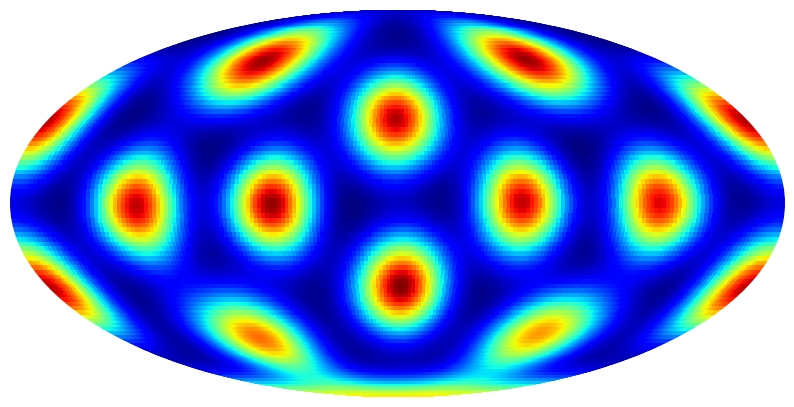

In [56]:
best = np.argmin(w)
X0_best = results1[best][0]
k = gaussian_kde(X0_best.T)
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
plot_utils.projection_mollweide(lambda x: k.pdf(x.T), ax)
plt.show()

In [97]:
N = 10
d_func = s3wd.ri_s3wd
d_args = {'p': 2, 'n_projs': 1000, 'device': device, 'h': None, 'n_rotations': 1}
results2 = [run_exp(dataiter, d_func, d_args,lr=0.01,device= device) for _ in range(N)]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [98]:
runtimes = [r[1] for r in results2]
nll=[r[2] for r in results2]
w = [r[3] for r in results2] 

print("Runtime: Mean =", np.mean(runtimes), "Std =", np.std(runtimes), "Min =", np.min(runtimes), "Max =", np.max(runtimes))
print("NLL: Mean =", np.mean(nll), "Std =", np.std(nll), "Min =", np.min(nll), "Max =", np.max(nll))
log_wd = np.log10(w)  
print("Log Wasserstein: Mean =", np.mean(log_wd), 
      "Std =", np.std(log_wd), 
      "Min =", np.min(log_wd), 
      "Max =", np.max(log_wd))

Runtime: Mean = 4.000512719154358 Std = 0.830420763259898 Min = 3.431792974472046 Max = 5.973562240600586
NLL: Mean = -4955.118603515625 Std = 48.20703005681981 Min = -5002.00634765625 Max = -4819.5087890625
Log Wasserstein: Mean = -3.0929592403112407 Std = 0.03930405634746472 Min = -3.1580966089285885 Max = -3.0219196439390075


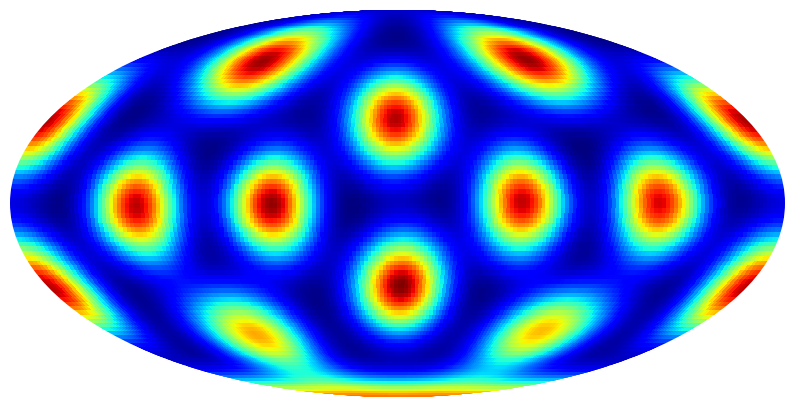

In [59]:
best = np.argmin(w)
X0_best = results1[best][0]
k = gaussian_kde(X0_best.T)
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
plot_utils.projection_mollweide(lambda x: k.pdf(x.T), ax)
plt.show()

In [99]:
N = 10
d_func = s3wd.ri_s3wd
d_args = {'p': 2, 'n_projs': 1000, 'device': device, 'h': None, 'n_rotations': 5}
results3 = [run_exp(dataiter, d_func, d_args,lr=0.01,device= device) for _ in range(N)]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [101]:
runtimes = [r[1] for r in results3]
nll=[r[2] for r in results3]
w = [r[3] for r in results3] 

print("Runtime: Mean =", np.mean(runtimes), "Std =", np.std(runtimes), "Min =", np.min(runtimes), "Max =", np.max(runtimes))
print("NLL: Mean =", np.mean(nll), "Std =", np.std(nll), "Min =", np.min(nll), "Max =", np.max(nll))
log_wd = np.log10(w)  
print("Log Wasserstein: Mean =", np.mean(log_wd), 
      "Std =", np.std(log_wd), 
      "Min =", np.min(log_wd), 
      "Max =", np.max(log_wd))

Runtime: Mean = 12.479699754714966 Std = 1.3591651236043523 Min = 10.974356174468994 Max = 14.27492904663086
NLL: Mean = -4973.631787109375 Std = 6.620372431620869 Min = -4983.56201171875 Max = -4959.29296875
Log Wasserstein: Mean = -3.43365471849434 Std = 0.0704770706039866 Min = -3.565187100460486 Max = -3.3218653304495267


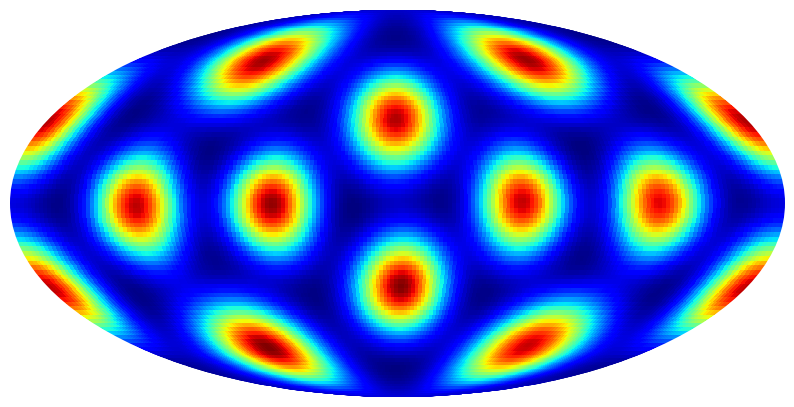

In [62]:
best = np.argmin(w)
X0_best = results3[best][0]
k = gaussian_kde(X0_best.T)
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
plot_utils.projection_mollweide(lambda x: k.pdf(x.T), ax)
plt.show()

In [63]:
N = 10
d_func = s3wd.ri_s3wd
d_args = {'p': 2, 'n_projs': 1000, 'device': device, 'h': None, 'n_rotations': 10}
results4 = [run_exp(dataiter, d_func, d_args, device) for _ in range(N)]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

In [64]:
runtimes = [r[1] for r in results4]
nll=[r[2] for r in results4]
w = [r[3] for r in results4] 

print("Runtime: Mean =", np.mean(runtimes), "Std =", np.std(runtimes), "Min =", np.min(runtimes), "Max =", np.max(runtimes))
print("NLL: Mean =", np.mean(nll), "Std =", np.std(nll), "Min =", np.min(nll), "Max =", np.max(nll))
log_wd = np.log(w)  
print("Log Wasserstein: Mean =", np.mean(log_wd), 
      "Std =", np.std(log_wd), 
      "Min =", np.min(log_wd), 
      "Max =", np.max(log_wd))

Runtime: Mean = 44.479462957382204 Std = 2.2525761675758247 Min = 40.66550087928772 Max = 48.789671182632446
NLL: Mean = -4969.922802734375 Std = 8.695313929774466 Min = -4984.83984375 Max = -4955.67138671875
Log Wasserstein: Mean = -8.172197346974952 Std = 0.15345357804136298 Min = -8.482725241766246 Max = -7.9703074800798


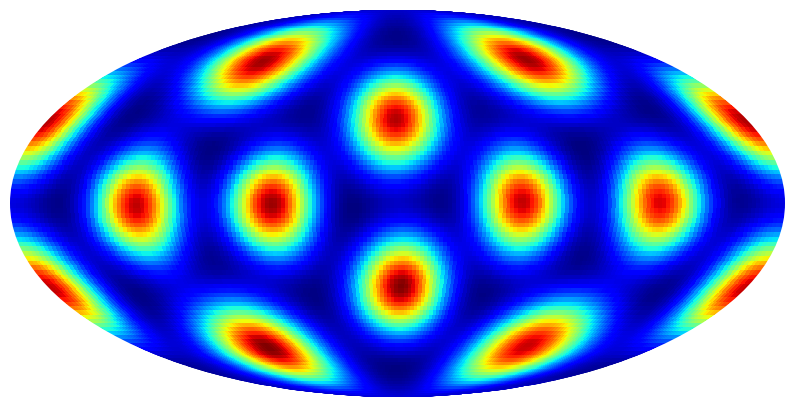

In [65]:
best = np.argmin(w)
X0_best = results4[best][0]
k = gaussian_kde(X0_best.T)
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
plot_utils.projection_mollweide(lambda x: k.pdf(x.T), ax)
plt.show()

In [66]:
N = 10
d_func = sswd.sswd
d_args = {'p': 2, 'num_projections': 1000, 'device': device}
results5 = [run_exp(dataiter, d_func, d_args, device) for _ in range(N)]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

In [75]:
runtimes = [r[1] for r in results5]
nll=[r[2] for r in results5]
w = [r[3] for r in results5] 

print("Runtime: Mean =", np.mean(runtimes), "Std =", np.std(runtimes), "Min =", np.min(runtimes), "Max =", np.max(runtimes))
print("NLL: Mean =", np.mean(nll), "Std =", np.std(nll), "Min =", np.min(nll), "Max =", np.max(nll))
log_wd = np.log10(w)  
print("Log Wasserstein: Mean =", np.mean(log_wd), 
      "Std =", np.std(log_wd), 
      "Min =", np.min(log_wd), 
      "Max =", np.max(log_wd))

Runtime: Mean = 190.55659697055816 Std = 1.9599275203066309 Min = 186.27007150650024 Max = 193.5014133453369
NLL: Mean = -4974.49794921875 Std = 0.9052662949758684 Min = -4975.76171875 Max = -4973.0732421875
Log Wasserstein: Mean = -3.3506393833582266 Std = 0.1025546971934456 Min = -3.474578519974311 Max = -3.195324742585555


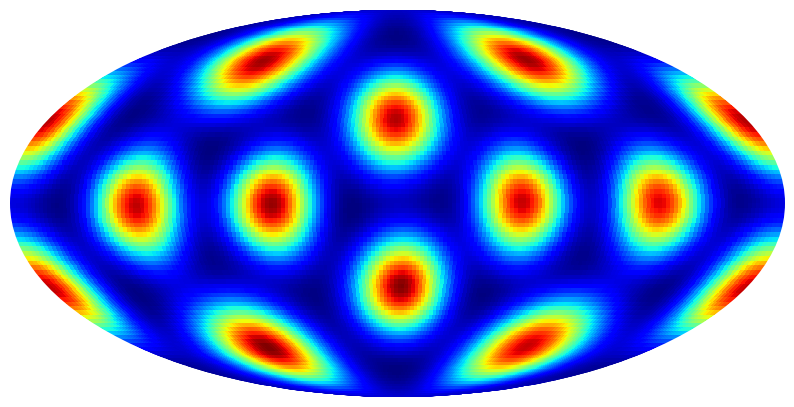

In [68]:
best = np.argmin(w)
X0_best = results5[best][0]
k = gaussian_kde(X0_best.T)
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
plot_utils.projection_mollweide(lambda x: k.pdf(x.T), ax)
plt.show()

In [77]:
N = 10
d_func = sswd.sswd
d_args = {'p': 2, 'num_projections': 1000, 'device': device}
results6 = [run_exp(dataiter, d_func, d_args, lr=0.05, device=device) for _ in range(N)]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [79]:
runtimes = [r[1] for r in results6]
nll=[r[2] for r in results6]
w = [r[3] for r in results6] 

print("Runtime: Mean =", np.mean(runtimes), "Std =", np.std(runtimes), "Min =", np.min(runtimes), "Max =", np.max(runtimes))
print("NLL: Mean =", np.mean(nll), "Std =", np.std(nll), "Min =", np.min(nll), "Max =", np.max(nll))
log_wd = np.log10(w)  
print("Log Wasserstein: Mean =", np.mean(log_wd), 
      "Std =", np.std(log_wd), 
      "Min =", np.min(log_wd), 
      "Max =", np.max(log_wd))

Runtime: Mean = 94.98495326042175 Std = 0.26850385546754846 Min = 94.56457614898682 Max = 95.37425470352173
NLL: Mean = -4974.46591796875 Std = 3.5018183262800764 Min = -4980.265625 Max = -4969.3037109375
Log Wasserstein: Mean = -3.367137594351681 Std = 0.12855573033219334 Min = -3.53766346674059 Max = -3.168857386898711
